In [2]:
import keras
import pandas as pd
from opencc import OpenCC

cc = OpenCC('s2twp') # 簡體中文 -> 繁體中文 (台灣, 包含慣用詞轉換)
train = pd.read_csv('ok.csv', index_col=0) # 讀取資料

# 將簡體轉為繁體
for i in range(train.size):
    train['review'].values[i] = cc.convert(train['review'].values[i])

train.head(20)

Using TensorFlow backend.


,review
label,
1,很快，好吃，味道足，量大
1,沒有送水沒有送水沒有送水
1,非常快，態度好。
1,方便，快捷，味道可口，快遞給力
1,菜味道很棒！送餐很及時！
1,今天師傅是不是手抖了，微辣格外辣！
1,"送餐快,態度也特別好,辛苦啦謝謝"
1,超級快就送到了，這麼冷的天氣騎士們辛苦了。謝謝你們。麻辣香鍋依然很好吃。
1,經過上次晚了2小時，這次超級快，20分鐘就送到了……


In [3]:
import jieba.posseg as pseg

def jieba_tokenizer(text):
    words = pseg.cut(text)
    return ' '.join([word for word, flag in words if flag != 'x'])

In [4]:
print(jieba_tokenizer('超級快就送到了，這麼冷的天氣騎士們辛苦了。謝謝你們。麻辣香鍋依然很好吃。'))

Building prefix dict from the default dictionary ...
Loading model from cache /var/folders/tb/rh2yw6nd28z6bmjxb_jt94q00000gn/T/jieba.cache
Loading model cost 0.634 seconds.
Prefix dict has been built successfully.


超級 快 就 送到 了 這麼 冷 的 天氣 騎士 們 辛苦 了 謝謝 你們 麻辣 香鍋 依然 很 好吃


In [5]:
train['review_tokenized'] = train.loc[:, 'review'].apply(jieba_tokenizer) # 將review分詞，會需要一點時間是正常der

In [6]:
# Tokenizer 顧名思義，即是將一段文字轉換成一系列的詞彙（Tokens），並為其建立字典。
# 這邊的 num_words=10000 代表我們限制字典只能包含 10,000 個詞彙，一旦字典達到這個大小以後，
# 剩餘的新詞彙都會被視為 Unknown，以避免字典過於龐大。

MAX_NUM_WORDS = 10000
tokenizer = keras.preprocessing.text.Tokenizer(num_words=MAX_NUM_WORDS)

In [7]:
train.head()

,review,review_tokenized
label,,
1,很快，好吃，味道足，量大,很快 好吃 味道 足 量 大
1,沒有送水沒有送水沒有送水,沒有 送水 沒有 送水 沒有 送水
1,非常快，態度好。,非常 快 態度 好
1,方便，快捷，味道可口，快遞給力,方便 快捷 味道 可口 快 遞 給 力
1,菜味道很棒！送餐很及時！,菜 味道 很棒 送餐 很 及時


In [8]:
corpus = train.review_tokenized
corpus.shape

(15144,)

In [9]:
corpus.head()

label
1         很快 好吃 味道 足 量 大
1      沒有 送水 沒有 送水 沒有 送水
1              非常 快 態度 好
1    方便 快捷 味道 可口 快 遞 給 力
1        菜 味道 很棒 送餐 很 及時
Name: review_tokenized, dtype: object

In [10]:
pd.DataFrame(corpus.iloc[:5],columns=['review'])

,review


In [11]:
# 呼叫 tokenizer 為我們查看所有文本，並建立一個字典
# 2. 建立一個空字典
# 3. 查看所有review，裏頭每出現一個字典裡頭沒有的詞彙，就為該詞彙指定一個字典裡頭還沒出現的索引數字，並將該詞彙放入字典

tokenizer.fit_on_texts(corpus)

In [12]:
# 4.利用建好的字典，將每個review裡頭包含的詞彙轉換成數字
x_train = tokenizer.texts_to_sequences(corpus)

In [13]:
len(x_train)

15144

In [14]:
# x_train 為一個 Python list，裡頭包含了每一筆review對應的數字序列。
x_train[:1] 

[[67, 3, 17, 349, 84, 78]]

In [15]:
# 利用 tokenizer.index_word 來將索引數字對應回本來的詞彙
for seq in x_train[:1]:
    print([tokenizer.index_word[idx] for idx in seq])

['很快', '好吃', '味道', '足', '量', '大']


In [16]:
# 每個review的序列長度並不相同
for seq in x_train[:20]:
    print(len(seq), seq[:5], ' ...')

6 [67, 3, 17, 349, 84]  ...
6 [25, 2963, 25, 2963, 25]  ...
4 [50, 26, 58, 11]  ...
8 [364, 2500, 17, 1075, 26]  ...
6 [39, 17, 406, 18, 7]  ...
9 [148, 171, 338, 540, 2964]  ...
9 [18, 26, 58, 13, 76]  ...
20 [15, 26, 20, 30, 1]  ...
15 [1787, 459, 109, 1, 105]  ...
11 [123, 32, 954, 5065, 2]  ...
10 [84, 78, 3, 255, 14]  ...
6 [3660, 2, 639, 6, 69]  ...
6 [17, 11, 18, 26, 318]  ...
6 [84, 349, 3, 18, 13]  ...
11 [76, 3, 84, 1788, 81]  ...
6 [439, 11, 2, 7, 34]  ...
11 [779, 3, 2, 1218, 318]  ...
16 [3, 34, 100, 13, 23]  ...
8 [17, 1289, 154, 18, 67]  ...
9 [84, 78, 17, 11, 18]  ...


In [17]:
max_seq_len = max([
    len(seq) for seq in x_train])
max_seq_len

289

In [18]:
# 為了方便之後的 NLP 模型處理一般會設定一個 MAX_SEQUENCE_LENGTH 來讓所有序列的長度一致。
# 長度超過此數字的序列尾巴會被刪掉；而針對原來長度不足的序列，我們則會在詞彙前面補零。

MAX_SEQUENCE_LENGTH = 25
x_train = keras.preprocessing.sequence.pad_sequences(x_train, maxlen=MAX_SEQUENCE_LENGTH)

In [19]:
x_train[0]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,  67,   3,  17, 349,  84,  78],
      dtype=int32)

In [20]:
x_train[:5]

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,   67,    3,   17,
         349,   84,   78],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,   25, 2963,   25,
        2963,   25, 2963],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,   50,
          26,   58,   11],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,  364, 2500,   17, 1075,   26,
         131,   24,  324],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,   39,   17,  406,
          18,    7,  325]], dtype=int32)

In [21]:
train['label'] = train.index

In [22]:
train.head()

,review,review_tokenized,label
label,,,
1,很快，好吃，味道足，量大,很快 好吃 味道 足 量 大,1
1,沒有送水沒有送水沒有送水,沒有 送水 沒有 送水 沒有 送水,1
1,非常快，態度好。,非常 快 態度 好,1
1,方便，快捷，味道可口，快遞給力,方便 快捷 味道 可口 快 遞 給 力,1
1,菜味道很棒！送餐很及時！,菜 味道 很棒 送餐 很 及時,1


In [23]:
train = train[['label', 'review', 'review_tokenized']]

In [24]:
train.reset_index(drop=True, inplace=True)
train.head()

,label,review,review_tokenized
0,1,很快，好吃，味道足，量大,很快 好吃 味道 足 量 大
1,1,沒有送水沒有送水沒有送水,沒有 送水 沒有 送水 沒有 送水
2,1,非常快，態度好。,非常 快 態度 好
3,1,方便，快捷，味道可口，快遞給力,方便 快捷 味道 可口 快 遞 給 力
4,1,菜味道很棒！送餐很及時！,菜 味道 很棒 送餐 很 及時


In [25]:
import numpy as np
y_train = train['label']
y_train = np.asarray(y_train).astype('float32')
y_train[:5]

array([1., 1., 1., 1., 1.], dtype=float32)

In [26]:
print(y_train.shape)

(15144,)


In [27]:
# One Hot Encoding
y_train = keras.utils.to_categorical(y_train)

y_train[:5] # [0, 1] -> label為1 (正面評論)

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [28]:
train.head()

,label,review,review_tokenized
0,1,很快，好吃，味道足，量大,很快 好吃 味道 足 量 大
1,1,沒有送水沒有送水沒有送水,沒有 送水 沒有 送水 沒有 送水
2,1,非常快，態度好。,非常 快 態度 好
3,1,方便，快捷，味道可口，快遞給力,方便 快捷 味道 可口 快 遞 給 力
4,1,菜味道很棒！送餐很及時！,菜 味道 很棒 送餐 很 及時


In [29]:
x_train

array([[   0,    0,    0, ...,  349,   84,   78],
       [   0,    0,    0, ..., 2963,   25, 2963],
       [   0,    0,    0, ...,   26,   58,   11],
       ...,
       [   0,    0,    0, ...,    0,    3,    3],
       [   0,    0,    0, ...,    0,   15,    3],
       [   0,    0,    0, ...,    0,   15,    3]], dtype=int32)

In [30]:
y_train

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [31]:
# 將dataset分為訓練資料集 / 驗證資料集
from sklearn.model_selection import train_test_split

VALIDATION_RATIO = 0.1
RANDOM_STATE = 9527

x_train, x_val,y_train, y_val = train_test_split(x_train, y_train,test_size=VALIDATION_RATIO,random_state=RANDOM_STATE)

In [32]:
print("Training Set")
print("-" * 10)
print(f"x_train: {x_train.shape}")
print(f"y_train : {y_train.shape}")
print("-"*10)

print("Validation Set")
print("-" * 10)
print(f"x_val:   {x_val.shape}")
print(f"y_val :   {y_val.shape}")
print("-" * 10)

# print("Test Set")
# print("-"*10)
# print(f"x_test: {x_test.shape}")
# print(f"y_test: {y_test.shape}")
# print("-" * 10)

Training Set
----------
x_train: (13629, 25)
y_train : (13629, 2)
----------
Validation Set
----------
x_val:   (1515, 25)
y_val :   (1515, 2)
----------


## 將dataset放進model進行訓練

In [33]:
# 基本參數設置，有幾個分類
NUM_CLASSES = 2 # 正面/負面

# 在語料庫裡有多少詞彙
MAX_NUM_WORDS = 10000

# 一個標題最長有幾個詞彙
MAX_SEQUENCE_LENGTH = 25

# 一個詞向量的維度
NUM_EMBEDDING_DIM = 256

# LSTM 輸出的向量維度
NUM_LSTM_UNITS = 128

In [54]:
from keras import Input
from keras.layers import Embedding, LSTM, concatenate, Dense, Dropout
from keras.models import Model, Sequential

# 定義 review 為模型輸入
# review為一個長度為 50 的數字序列
review_input = Input(
    shape=(MAX_SEQUENCE_LENGTH, ), 
    dtype='int32')

# 詞嵌入層
# 經過詞嵌入層的轉換，review變成一個詞向量的序列，
# 而每個詞向量的維度為 256
embedding_layer = Embedding(
    MAX_NUM_WORDS, NUM_EMBEDDING_DIM)
review_embedded = embedding_layer(
    review_input)

# LSTM 層
# review經過此層後
# 為一個 128 維度向量
shared_lstm = LSTM(NUM_LSTM_UNITS)
review_output = shared_lstm(review_embedded)

# 全連接層搭配 Softmax Activation
# 回傳review屬於正面/負面的可能機率
dense =  Dense(units=NUM_CLASSES,activation='softmax')
predictions = dense(review_output)

# 我們的模型就是將數字序列的輸入，轉換
# 成 2 個分類的機率的所有步驟 / 層的總和
model = Model(inputs=[review_input],outputs=predictions)

In [35]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 25)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 25, 256)           2560000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               197120    
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 258       
Total params: 2,757,378
Trainable params: 2,757,378
Non-trainable params: 0
_________________________________________________________________


In [36]:
x_train[:9527].shape # 確認前9527筆資料的shape

(9527, 25)

In [37]:
model.compile(
    optimizer='rmsprop',
    loss='categorical_crossentropy',
    metrics=['accuracy'])

In [38]:
# 決定一次要放多少review給模型訓練
BATCH_SIZE = 512

# 決定模型要看整個訓練資料集幾遍
NUM_EPOCHS = 10

# 實際訓練模型
history = model.fit(
    # 輸入是一個長度為 25 的數字序列
    x=[x_train], 
    y=y_train,
    batch_size=BATCH_SIZE,
    epochs=NUM_EPOCHS,
    # 每個 epoch 完後計算驗證資料集上的 Loss 以及準確度
    validation_data=(
        [x_val], 
        y_val
    ),
    # 每個 epoch 隨機調整訓練資料集
    # 裡頭的數據以讓訓練過程更穩定
    shuffle=True
)


Train on 13629 samples, validate on 1515 samples
Epoch 1/10
13629/13629 [==============================] - 14s 1ms/step - loss: 0.4004 - accuracy: 0.8099 - val_loss: 0.2753 - val_accuracy: 0.8990
Epoch 2/10
13629/13629 [==============================] - 14s 1ms/step - loss: 0.2246 - accuracy: 0.9144 - val_loss: 0.2353 - val_accuracy: 0.9116
Epoch 3/10
13629/13629 [==============================] - 14s 994us/step - loss: 0.1864 - accuracy: 0.9298 - val_loss: 0.2326 - val_accuracy: 0.9149
Epoch 4/10
13629/13629 [==============================] - 13s 942us/step - loss: 0.1583 - accuracy: 0.9398 - val_loss: 0.2584 - val_accuracy: 0.9096
Epoch 5/10
13629/13629 [==============================] - 13s 949us/step - loss: 0.1399 - accuracy: 0.9484 - val_loss: 0.2530 - val_accuracy: 0.9102
Epoch 6/10
13629/13629 [==============================] - 13s 968us/step - loss: 0.1226 - accuracy: 0.9559 - val_loss: 0.2625 - val_accuracy: 0.9149
Epoch 7/10
13629/13629 [==============================] - 13

In [125]:
from keras import optimizers
model1 = Sequential()
#model1.add(Embedding(max_features, output_dim=256))
model1.add(Embedding(MAX_NUM_WORDS, 256))
model1.add(LSTM(128, activation="relu"))
model1.add(Dropout(0.02))
model1.add(Dense(2))
review_embedded = embedding_layer(
    review_input)

adamw=optimizers.SGD(lr=0.005)
#, decay=1e-4
              
model1.compile(
    optimizer=adamw,
    loss='categorical_crossentropy',
    metrics=['accuracy'])


history1 = model1.fit(
    # 輸入是一個長度為 25 的數字序列
    x=[x_train], 
    y=y_train,
    batch_size=512,
    epochs=NUM_EPOCHS,
    # 每個 epoch 完後計算驗證資料集上的 Loss 以及準確度
    validation_data=(
        [x_val], 
        y_val
    ),
    # 每個 epoch 隨機調整訓練資料集
    # 裡頭的數據以讓訓練過程更穩定
    shuffle=True
)

Train on 13629 samples, validate on 1515 samples
Epoch 1/10
13629/13629 [==============================] - 13s 988us/step - loss: 1.0299 - accuracy: 0.5256 - val_loss: 0.6858 - val_accuracy: 0.5353
Epoch 2/10
13629/13629 [==============================] - 11s 834us/step - loss: 0.6860 - accuracy: 0.5265 - val_loss: 0.6845 - val_accuracy: 0.5353
Epoch 3/10
13629/13629 [==============================] - 11s 830us/step - loss: 0.6846 - accuracy: 0.5265 - val_loss: 0.6832 - val_accuracy: 0.5353
Epoch 4/10
13629/13629 [==============================] - 11s 832us/step - loss: 0.6833 - accuracy: 0.5265 - val_loss: 0.6820 - val_accuracy: 0.5353
Epoch 5/10
13629/13629 [==============================] - 12s 847us/step - loss: 0.6819 - accuracy: 0.5266 - val_loss: 0.6808 - val_accuracy: 0.5353
Epoch 6/10
13629/13629 [==============================] - 12s 850us/step - loss: 0.6806 - accuracy: 0.5273 - val_loss: 0.6795 - val_accuracy: 0.5353
Epoch 7/10
13629/13629 [==============================] -

{'val_loss': [0.685768455876769, 0.6844928584476508, 0.6832345912165374, 0.681998337377416, 0.6807578670703145, 0.6794922097287949, 0.6781832485309135, 0.6768377715998357, 0.675483778719068, 0.6741020792388287], 'val_accuracy': [0.5353135466575623, 0.5353135466575623, 0.5353135466575623, 0.5353135466575623, 0.5353135466575623, 0.5353135466575623, 0.5353135466575623, 0.5353135466575623, 0.6356435418128967, 0.6356435418128967], 'loss': [1.0298862979280703, 0.6859584487239371, 0.6845652777159045, 0.6832884573754531, 0.6818733658091899, 0.6806075638961666, 0.6791863664946436, 0.6777934005495055, 0.6763185360730984, 0.6748197695743452], 'accuracy': [0.5256438, 0.5265243, 0.5265243, 0.5265243, 0.5265977, 0.5273314, 0.5298261, 0.5371634, 0.56277055, 0.6175068]}


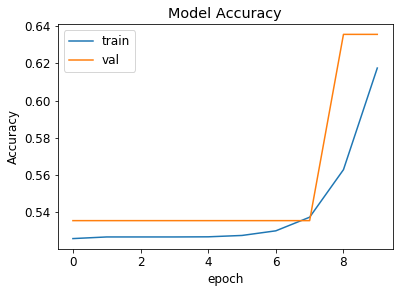

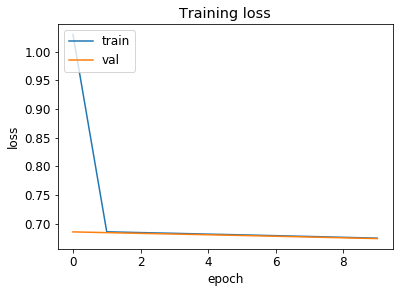

In [126]:
import matplotlib.pyplot as plt

# graph (accuracy)
print(history1.history)
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'val'], loc='upper left')
plt.title('Model Accuracy')
plt.show()

# graph (loss)
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'], loc='upper left')
plt.title('Training loss')
plt.show()

In [46]:
import matplotlib.pyplot as plt

# graph (accuracy)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'val'], loc='upper left')
plt.title('Model Accuracy')
plt.show()

# graph (loss)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'], loc='upper left')
plt.title('Training loss')
plt.show()

AttributeError: 'History' object has no attribute 'history1'

## craweld test data

In [67]:
test_csv = pd.read_csv('test1.csv', index_col=0) # 讀取資料

test_csv.head()

# print(''.join([i for i in test_haidelao['caption'].values[1] if not i.isdigit()])

test_haidelao = pd.DataFrame(test_csv['caption'].astype(str))
test_haidelao['rating'] = test_csv['rating'].astype(str)

test_haidelao.loc[test_haidelao.rating=='4' , 'rating'] = 1
test_haidelao.loc[test_haidelao.rating=='5' , 'rating'] = 1
test_haidelao.loc[test_haidelao.rating!=1, 'rating'] = 0

test_haidelao = test_haidelao[test_haidelao['caption'] != 'nan']

test_haidelao.reset_index(drop=True, inplace=True)
test_haidelao

KeyError: 'caption'

In [436]:
# 分詞
test_haidelao['review_tokenized'] = test_haidelao.loc[:, 'caption'].apply(jieba_tokenizer)

# 利用建好的字典，將每個review裡頭包含的詞彙轉換成數字 
x_test_haidelao = tokenizer.texts_to_sequences(test_haidelao.review_tokenized)

# 長度不足25的在前面補零
x_test_haidelao = keras.preprocessing.sequence.pad_sequences(x_test_haidelao, maxlen=MAX_SEQUENCE_LENGTH)

# predict!
predictions = model.predict([x_test_haidelao])

In [437]:
# test_df = DataFrame ([label for label in np.argmax(np.array(y_test), axis=1)],columns=['label'])
test_haidelao['label'] = [label for label in np.argmax(predictions, axis=1)]
# test_df['Category'] = [idx for idx in np.argmax(predictions, axis=1)]
test_haidelao['correct'] = test_haidelao['label'] == test_haidelao['rating']

test_haidelao[['caption', 'label', 'rating', 'correct']]

,caption,label,rating,correct
0,平日2人去不用候位太久覺得很棒，雖然用餐不限時間但是也不會讓客人等太久，很有效率的店，安排的...,1,1,True
1,員工服務招待的很棒！覺得除了食物也值回票價！ 服務我們這桌的茈珞、嘉祥、超宇跟奕維讓我們印象...,1,1,True
2,服務很好，東西好吃，又有美甲跟擦鞋服務。,1,1,True
3,桌邊服務品質好,1,1,True
4,海底撈服務沒什麼好挑的 湯底推豬肚雞 真材實料CP值很高,1,1,True
5,桌邊服務很好 但是等待時間蠻久的，如果沒有訂位還是要有心理準備,0,1,False
6,店員（陳冠宇） 服務態度是我吃海底撈這麼多次以來第一個讓我想寫評論的人，服務態度真的真的很好...,0,1,False
7,服務人員～陳冠宇服務親切、貼心、有效率👍,1,1,True
8,服務優質,0,1,False
9,乾淨，服務好，小孩有地方玩，媽媽可以好好吃飯。,1,1,True


In [439]:
print('Crawled Accuracy: ', (test_haidelao[test_haidelao.correct == True].count()['correct'])/len(test_haidelao.index))

Crawled Accuracy:  0.6176470588235294


## test data from original dataset

In [422]:
# predict!
predictions = model.predict([x_test])

test_df = DataFrame ([label for label in np.argmax(np.array(y_test), axis=1)],columns=['real'])
test_df['predict'] = [label for label in np.argmax(predictions, axis=1)]
test_df['correct'] = test_df['real'] == test_df['predict']

print(test_df[test_df.correct == True].count()['correct'])
test_df

real       266
predict    266
correct    937
dtype: int64


,real,predict,correct
0,0,0,True
1,1,1,True
2,0,0,True
3,0,0,True
4,1,1,True
...,...,...,...
1074,0,0,True
1075,0,0,True
1076,0,0,True
1077,0,0,True


In [426]:
print('Accuracy: ', (test_df[test_df.correct == True].count()['correct'])/len(test_df.index))

Accuracy:  0.8683966635773864


In [87]:
test_csv = pd.read_csv('hai500.csv', index_col=0) # 讀取資料

test_csv.head()

# print(''.join([i for i in test_haidelao['caption'].values[1] if not i.isdigit()])

test_haidelao = pd.DataFrame(test_csv['caption'].astype(str))
test_haidelao['rating'] = test_csv['rating'].astype(str)

# rating 3以下評價視為負評
test_haidelao.loc[test_haidelao.rating=='4' , 'rating'] = 1
test_haidelao.loc[test_haidelao.rating=='5' , 'rating'] = 1
test_haidelao.loc[test_haidelao.rating!=1, 'rating'] = 0

test_haidelao = test_haidelao[test_haidelao['caption'] != 'nan']

test_haidelao.reset_index(drop=True, inplace=True)
test_haidelao

,caption,rating
0,平日2人去不用候位太久覺得很棒，雖然用餐不限時間但是也不會讓客人等太久，很有效率的店，安排的...,1
1,員工服務招待的很棒！覺得除了食物也值回票價！ 服務我們這桌的茈珞、嘉祥、超宇跟奕維讓我們印象...,1
2,服務很好，東西好吃，又有美甲跟擦鞋服務。,1
3,桌邊服務品質好,1
4,海底撈服務沒什麼好挑的 湯底推豬肚雞 真材實料CP值很高,1
5,桌邊服務很好 但是等待時間蠻久的，如果沒有訂位還是要有心理準備,1
6,店員（陳冠宇） 服務態度是我吃海底撈這麼多次以來第一個讓我想寫評論的人，服務態度真的真的很好...,1
7,服務人員～陳冠宇服務親切、貼心、有效率👍,1
8,服務優質,1
9,乾淨，服務好，小孩有地方玩，媽媽可以好好吃飯。,1


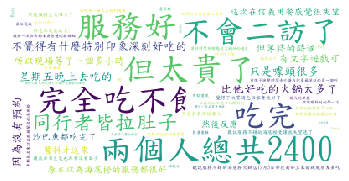

KeyError: 'review'

In [110]:
import nltk
from wordcloud import WordCloud
import numpy as np # linear algebra
import pandas as pd 
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

from subprocess import check_output
from wordcloud import WordCloud, STOPWORDS

#mpl.rcParams['figure.figsize']=(8.0,6.0)    #(6.0,4.0)

mpl.rcParams['font.size']=12                #10 
mpl.rcParams['savefig.dpi']=100             #72 
mpl.rcParams['figure.subplot.bottom']=.1 

stopwords = set(STOPWORDS)

wc=WordCloud(font_path = '/Desktop/kaiu.ttf',background_color = 'White', max_words = 100)

postive = test_haidelao[test_haidelao['rating'] != 0]
negative = test_haidelao[test_haidelao['rating'] != 1]

wordcloud = WordCloud(
                          font_path = '/Desktop/kaiu.ttf',
                          background_color='white',
                          stopwords=stopwords,
                          max_words=200,
                          max_font_size=40, 
                          random_state=42
                         )
#.generate(str(test['review']))

wordcloud.generate(str(negative['caption']))
#wordcloud.generate(str(a))
print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()
fig.savefig("word2.png", dpi=1000)
negative['review']